In [1]:
import requests
import csv
import pandas as pd
import json
import os
import geopandas as gpd
import geodatasets
import matplotlib.pyplot as plt
import numpy as np
import re
import datetime
import polars as pl
import statsmodels as sm
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from statsmodels.discrete.discrete_model import Poisson
import warnings
warnings.filterwarnings('ignore')

In [2]:
"""assignments
1. copy ethan - merge dmv counts with zip code features (find correlations?)
2. python model statsmodels to fit distribution to the data 
for every zip code, find total number of electric vehicles registered in the year
given a zip code and a year, how many vehicles were registered? 
other features, number of chargers etc. 
what he wants to see is a poisson distribution fit on that data, fit for all 100 zip codes
basically, create a table with labels [zip, lambda]. """


'assignments\n1. copy ethan - merge dmv counts with zip code features (find correlations?)\n2. python model statsmodels to fit distribution to the data \nfor every zip code, find total number of electric vehicles registered in the year\ngiven a zip code and a year, how many vehicles were registered? \nother features, number of chargers etc. \nwhat he wants to see is a poisson distribution fit on that data, fit for all 100 zip codes\nbasically, create a table with labels [zip, lambda]. '

In [3]:

_2019 = pd.read_csv('datasets/vehicle_fuel_types/2019_vehicle_fuel_types.csv')
_2020 = pd.read_csv('datasets/vehicle_fuel_types/2020_vehicle_fuel_types.csv')
_2021 = pd.read_csv('datasets/vehicle_fuel_types/2021_vehicle_fuel_types.csv')
_2022 = pd.read_csv('datasets/vehicle_fuel_types/2022_vehicle_fuel_types.csv')
_2023 = pd.read_csv('datasets/vehicle_fuel_types/2023_vehicle_fuel_types.csv')
_2024 = pd.read_csv('datasets/vehicle_fuel_types/2024_vehicle_fuel_types.csv')
_2019['num_vehicles'].sum(),_2020['num_vehicles'].sum() , _2021['num_vehicles'].sum(),_2022['num_vehicles'].sum(), _2023['num_vehicles'].sum(), _2024['num_vehicles'].sum(),

(31137994, 31233841, 29599519, 31043241, 31113830, 31127451)

In [4]:
_2019.zipcode = _2019.zipcode.replace('Other', 'OOS')

In [5]:
def fix(df):
    df['zipcode'] = df.zipcode.astype('str')
    ret = df[df.fuel == 'Battery Electric']
    ret = ret.groupby('zipcode')['num_vehicles'].sum()
    
    return ret

In [6]:
df24 = fix(_2024)
df23 = fix(_2023)
df22 = fix(_2022)
df21 = fix(_2021)
df20 = fix(_2020)
df19 = fix(_2019)
dfl = [df19,df20,df21,df22,df23,df24]

In [7]:
df23.index

Index(['90001', '90002', '90003', '90004', '90005', '90006', '90007', '90008',
       '90009', '90010',
       ...
       '98922', '98944', '99026', '99033', '99156', '99163', '99208', '99224',
       '99835', 'OOS'],
      dtype='object', name='zipcode', length=2245)

In [8]:
df = pd.concat(dfl, axis = 1)
cols = [2019,2020,2021,2022,2023,2024]
df.columns = cols

In [9]:
df

2019   2020   2021   2022   2023    2024
zipcode                                           
90000      4.0    4.0    NaN    NaN    NaN     NaN
90001     10.0   21.0   36.0   52.0   91.0   168.0
90002     22.0   31.0   37.0   60.0   98.0   167.0
90003     16.0   25.0   30.0   63.0  121.0   197.0
90004    250.0  345.0  439.0  643.0  897.0  1292.0
...        ...    ...    ...    ...    ...     ...
99212      NaN    NaN    NaN    NaN    NaN     1.0
99337      NaN    NaN    NaN    NaN    NaN     1.0
99338      NaN    NaN    NaN    NaN    NaN     1.0
99362      NaN    NaN    NaN    NaN    NaN     1.0
99515      NaN    NaN    NaN    NaN    NaN     1.0

[2724 rows x 6 columns]

In [10]:
_19 = pd.read_csv('datasets/dldata/2019.csv')
_19['Zip Code'] = _19['Zip Code'].replace('Other', 'OOS')
_20 = pd.read_csv('datasets/dldata/2020.csv')
_21 = pd.read_csv('datasets/dldata/2021.csv')
_22 = pd.read_csv('datasets/dldata/2022.csv')
_23 = pd.read_csv('datasets/dldata/2023.csv')
_24 = pd.read_csv('datasets/dldata/2024.csv')
df_list = [_19,_20,_21,_22,_23,_24]

In [11]:
for df in df_list:
    df.columns = ['date','zipcode','modelyr','fuel','make','duty','num_vehicles']

In [12]:
non_ev_fuels = ['Gasoline', 'Diesel and Diesel Hybrid',
       'Other', 'Flex-Fuel', 'Hybrid Gasoline', 'Natural Gas',
       'Plug-in Hybrid', 'Hydrogen Fuel Cell', 'Unk']

In [13]:
def fix_alt(df):
    df['zipcode'] = df.zipcode.astype('str')
    df['fuel'] = df['fuel'].replace(non_ev_fuels, 'not battery')
    ret = df
    ret = ret.groupby(['zipcode','fuel'])['num_vehicles'].sum()
    return ret

def fix_alt2(df):
    df['zipcode'] = df.zipcode.astype('str')
    df['fuel'] = df['fuel'].replace(non_ev_fuels, 'not battery')
    ret = df
    ret = ret.groupby(['zipcode','fuel'])['num_vehicles'].sum()
    return ret

In [14]:
t19 = fix_alt(_19)
t20 = fix_alt(_20)
t21 = fix_alt(_21)
t22 = fix_alt(_22)
t23 = fix_alt(_23)
t24 = fix_alt(_24)

In [15]:
t19

zipcode  fuel            
90000    Battery Electric         4
         not battery            326
90001    Battery Electric        10
         not battery          34699
90002    Battery Electric        22
                              ...  
99709    not battery             19
99801    not battery             26
99999    not battery             11
OOS      Battery Electric      3108
         not battery         723173
Name: num_vehicles, Length: 4867, dtype: int64

In [16]:
df = pd.concat([t19,t20,t21,t22,t23,t24],axis=1)
fuel_df = pd.concat([t19,t20,t21,t22,t23,t24],axis=1)
df.columns = cols
#tt = tt[tt['fuel'] == 'Battery Electric']
df


2019     2020     2021     2022     2023     2024
zipcode fuel                                                                  
90000   Battery Electric      4.0      4.0      NaN      NaN      NaN      NaN
        not battery         326.0    343.0    223.0    225.0    321.0    318.0
90001   Battery Electric     10.0     21.0     36.0     52.0     91.0    168.0
        not battery       34699.0  34587.0  33429.0  35455.0  34954.0  34256.0
90002   Battery Electric     22.0     31.0     37.0     60.0     98.0    167.0
...                           ...      ...      ...      ...      ...      ...
99717   not battery           NaN      NaN      NaN      NaN      NaN      1.0
99786   not battery           NaN      NaN      NaN      NaN      NaN      1.0
99830   not battery           NaN      NaN      NaN      NaN      NaN      1.0
99921   not battery           NaN      NaN      NaN      NaN      NaN      1.0
99993   not battery           NaN      NaN      NaN      NaN      NaN      1.0

[9343 rows x 6 columns]

In [17]:
# imputing based on the distribution of all other cars

df = df.reset_index()
df2 = df[df['fuel'] == 'Battery Electric']
nonbat = None
for zip in df2.zipcode.unique():
    imp = IterativeImputer(max_iter=10, random_state=0)

    both = df[df['zipcode'] == zip ]
    battery = both[both['fuel'] == 'Battery Electric']
    nonbat = both[both['fuel'] != 'Battery Electric']
    if nonbat.isnull().values.any() or len(nonbat) < 1: continue
    if battery.isnull().values.any() :
        idx = battery.index.astype(int)[0]
        res = imp.fit_transform(np.stack(np.array(both[[2019,2020,2021,2022,2023,2024]]),axis=1))
        repl = np.split(res, 2, axis=1)[0].flatten()
        df.iloc[idx, 2:] = repl

In [18]:
df2 = df[df['fuel'] == 'Battery Electric']
df2 = df2.fillna(0) # if there are no non-battery cars, fill with 0
df2 = df2.set_index(['zipcode']).drop('fuel', axis=1)
evs_cum_peryr = df2
evs_cum_peryr

2019   2020   2021   2022   2023    2024
zipcode                                           
90000      4.0    4.0    4.0    4.0    4.0     4.0
90001     10.0   21.0   36.0   52.0   91.0   168.0
90002     22.0   31.0   37.0   60.0   98.0   167.0
90003     16.0   25.0   30.0   63.0  121.0   197.0
90004    250.0  345.0  439.0  643.0  897.0  1292.0
...        ...    ...    ...    ...    ...     ...
99212      0.0    0.0    0.0    0.0    0.0     1.0
99337      0.0    0.0    0.0    0.0    0.0     1.0
99338      0.0    0.0    0.0    0.0    0.0     1.0
99362     19.0   28.0   33.0   29.0   23.0    27.0
99515     16.0   15.0   17.0   15.0   13.0    14.0

[2724 rows x 6 columns]

In [19]:
df2

2019   2020   2021   2022   2023    2024
zipcode                                           
90000      4.0    4.0    4.0    4.0    4.0     4.0
90001     10.0   21.0   36.0   52.0   91.0   168.0
90002     22.0   31.0   37.0   60.0   98.0   167.0
90003     16.0   25.0   30.0   63.0  121.0   197.0
90004    250.0  345.0  439.0  643.0  897.0  1292.0
...        ...    ...    ...    ...    ...     ...
99212      0.0    0.0    0.0    0.0    0.0     1.0
99337      0.0    0.0    0.0    0.0    0.0     1.0
99338      0.0    0.0    0.0    0.0    0.0     1.0
99362     19.0   28.0   33.0   29.0   23.0    27.0
99515     16.0   15.0   17.0   15.0   13.0    14.0

[2724 rows x 6 columns]

In [20]:
ev_regs_peryr = df2.diff(axis=1)
ev_regs_peryr = ev_regs_peryr.drop(2019,axis=1)

zip_lambs = {}
for i in range(len(ev_regs_peryr)):
    row = ev_regs_peryr.iloc[i]
    model = Poisson(endog=row, exog = [1,2,3,4,5]).fit(disp=0)
    zip_lambs[row.name] = model.params[0]

In [21]:
zip_lambs

{'90000': -21.80417787159507,
 '90001': 4.380002877378957,
 '90002': 3.5960059156046866,
 '90003': 6.199706737769922,
 '90004': 63.58181818245792,
 '90005': 45.70909090956817,
 '90006': 24.0363636366387,
 '90007': 8.999982182228173,
 '90008': 31.709090909440903,
 '90009': 0.049216540130773735,
 '90010': 20.36363636367645,
 '90011': 9.072710704869525,
 '90012': 48.563636364139576,
 '90013': 13.490908891357773,
 '90014': 7.636293950220423,
 '90015': 34.05454545491676,
 '90016': 49.14545454596304,
 '90017': 17.272727268395897,
 '90018': 26.89090909121505,
 '90019': 76.36363636439229,
 '90020': 34.92727272765197,
 '90021': 2.478528912813584,
 '90022': 8.745431562336826,
 '90023': 5.854131025650512,
 '90024': 81.69090909171345,
 '90025': 110.36363636470139,
 '90026': 62.92727272790651,
 '90027': 68.45454545522949,
 '90028': 42.818181818632794,
 '90029': 17.690909088136596,
 '90031': 27.018181818488973,
 '90032': 29.89090909124257,
 '90033': 6.5634325613488125,
 '90034': 95.07272727365329,
 

<Axes: >

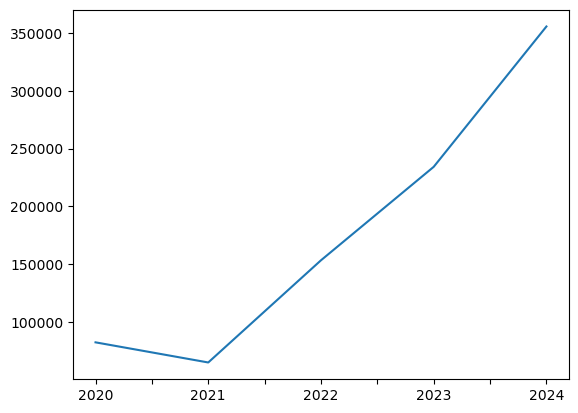

In [22]:

ev_regs_peryr.sum().plot()



In [23]:
url_geo_evonly = 'https://developer.nrel.gov/api/alt-fuel-stations/v1.geojson?api_key=ZXxi5VGIY0iCen0L0ertvSJDFmeKd8JF0cbrMIlY&state=CA&fuel_type=ELEC'
with requests.get(url_geo_evonly) as response:
    geodata = response.json()


In [24]:
geodf = gpd.GeoDataFrame.from_features(geodata, crs = 4326)

In [25]:
ev_stations_df = pd.read_csv('datasets/ev_stations/ev_CA.csv')
zip_counts = ev_stations_df.zip.value_counts()

In [26]:
zip_geodata = gpd.GeoDataFrame.from_file('datasets/alt data/ZipCodes_-1049704744535259894.geojson')

In [27]:
df = pd.read_csv('datasets/dldata/2024.csv')
df = df[df['Fuel'] == 'Battery Electric']
df = df.groupby('ZIP Code')['Vehicles'].sum().reset_index()
df['zipcode'] = df['ZIP Code']
df = df.drop('ZIP Code',axis = 1).set_index('zipcode')

In [28]:
zip_geodata['zipcode'] = zip_geodata['ZIP_CODE']
zip_geodata = zip_geodata.drop('ZIP_CODE', axis = 1)



In [29]:
zip_geodata['zipcode']
newdf = zip_geodata.join(df, on='zipcode')


In [ ]:
# not running below cell to lower filesize, instead included a screenshot of the plots

In [ ]:
m = newdf.explore(
    column='Vehicles',
    k=4,
    popup=['PO_NAME','zipcode','Vehicles'])

geodf.explore(
    m=m,
    marker_kwds=dict(radius=3, fill=False),
    color='Orange',
    tooltip = 'street_address',
    tooltip_kwds=dict(labels=False),
    column='fuel_type_code')

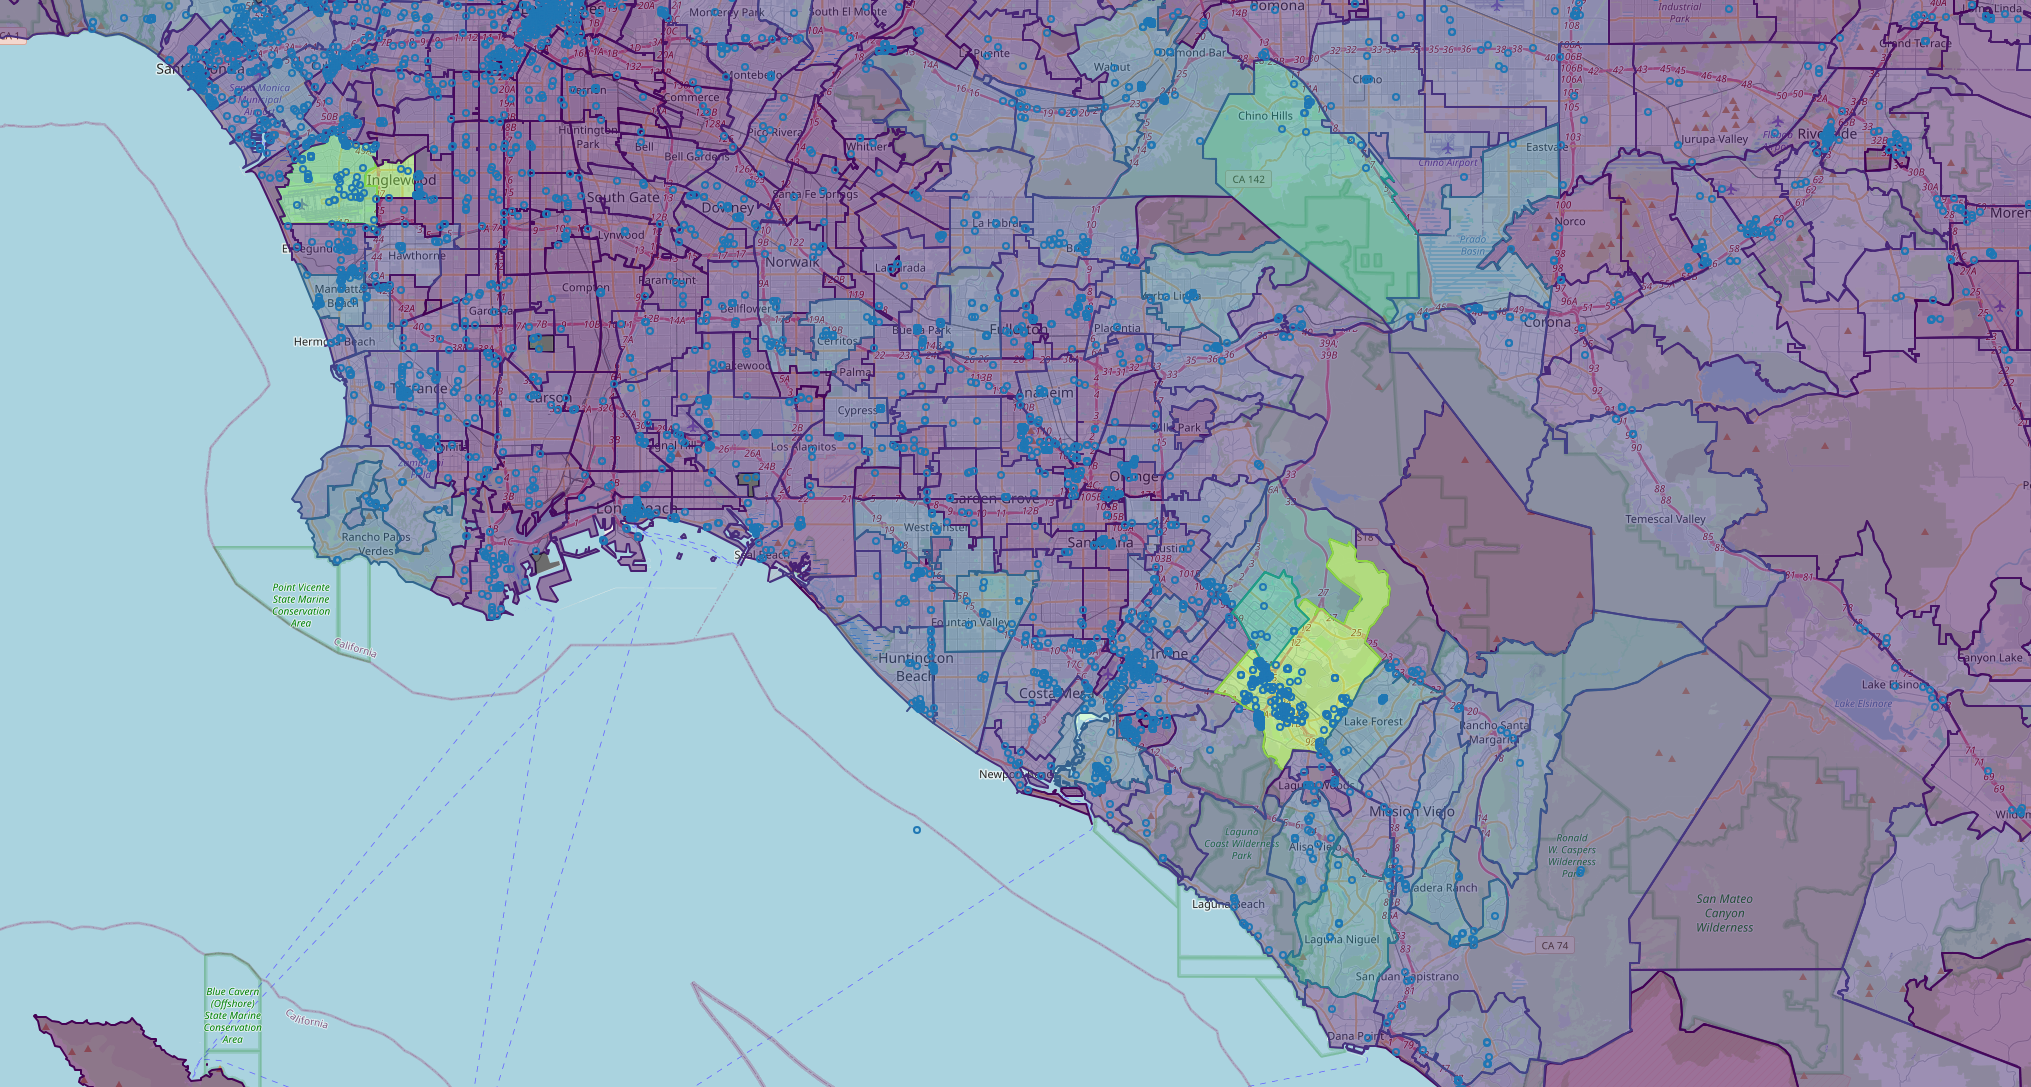

In [35]:
from IPython.display import Image
Image("assets/num_evs_fig.png")

In [ ]:
newdf1 = newdf.dropna()
newdf1 = newdf1[newdf1['POPULATION']>10]
newdf1['ev_per_capita'] = (newdf1['Vehicles']/(newdf1['POPULATION']+1)).round(4)*1000
newdf1.explore(
    column='ev_per_capita',
    
    scheme="naturalbreaks",  # use mapclassify's natural breaks scheme
    #legend=True,  # show legend
    k=10,  # use 10 bins
    #tooltip=False,  # hide tooltip
    #popup=["ep_pci"],  # show popup (on-click)
    #legend_kwds=dict(colorbar=False),  # do not use colorbar
    #name="PCI",  # name of the layer in the map)
)


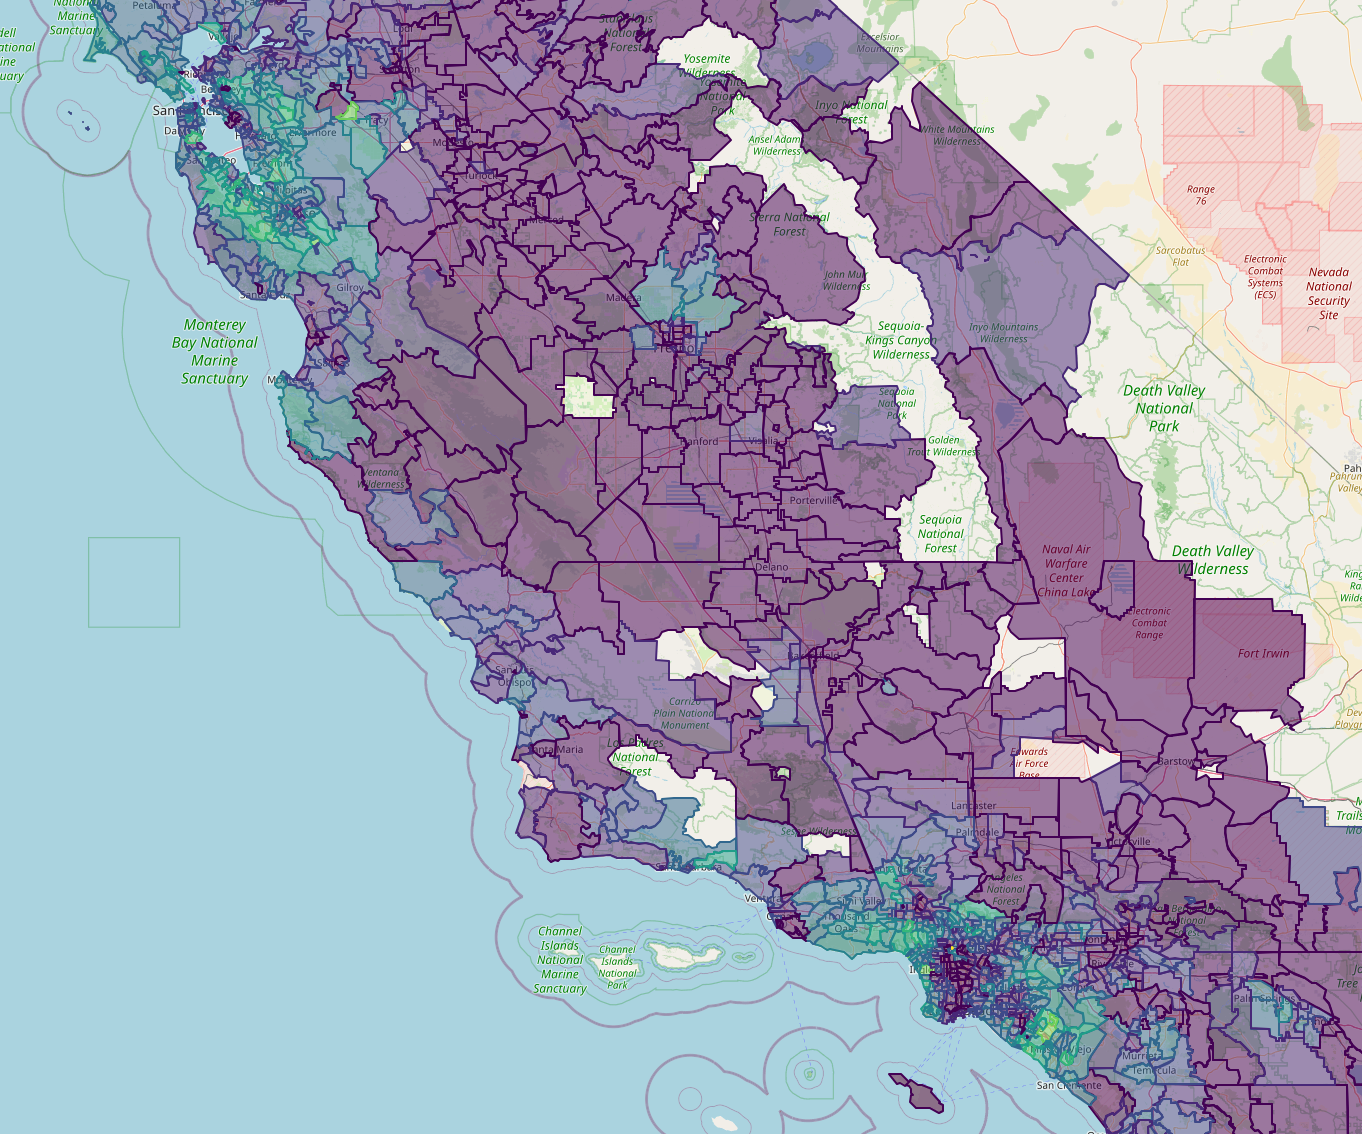

In [36]:
Image("assets/evs_per_capita_fig.png")